In [1]:
import sys
import os

sys.path.append(os.path.abspath("../"))

import jax.numpy as jnp
import jax.nn as jnn
from src.fd_scheme import fd_solve
from src.analytical import u_exact
from src.plotting import plot_solution, plot_training_loss, plot_all_heatmaps, plot_scheme_errors_t1, plot_scheme_errors_t2
from src.nn.model import MLP
from src.nn.train import train_pinn
from src.nn.evaluation import compare_nn_and_exact, test_explicit_scheme
from src.experiment import run_architecture_sweep

# Part B
Plots for $\Delta x = 1/10$ and $\Delta t = 1/100$

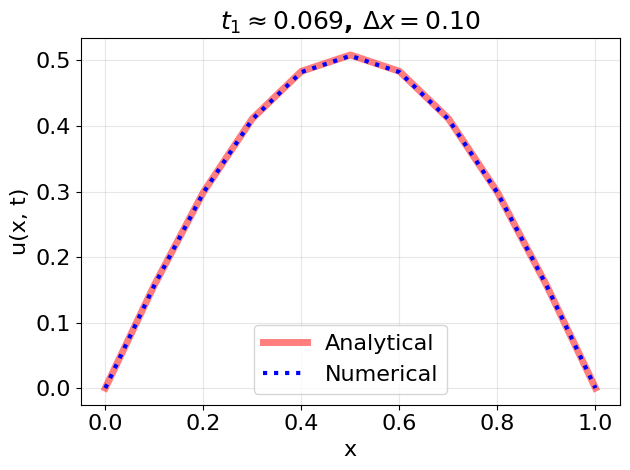

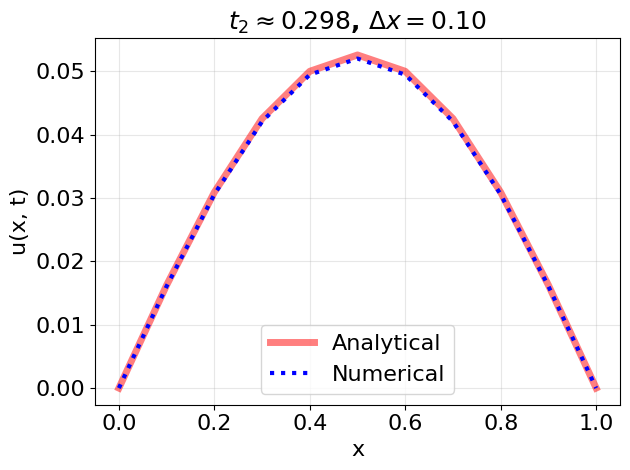

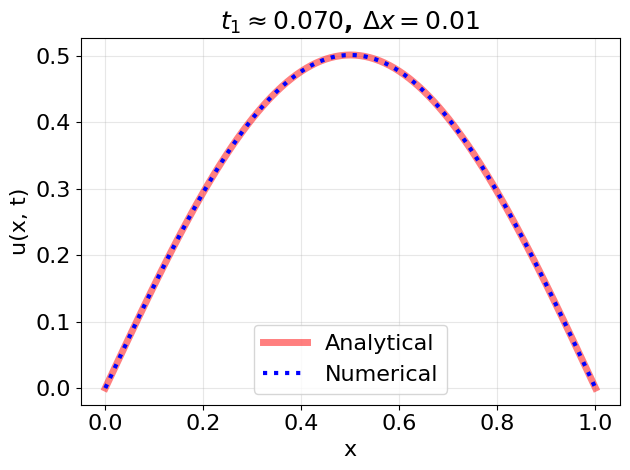

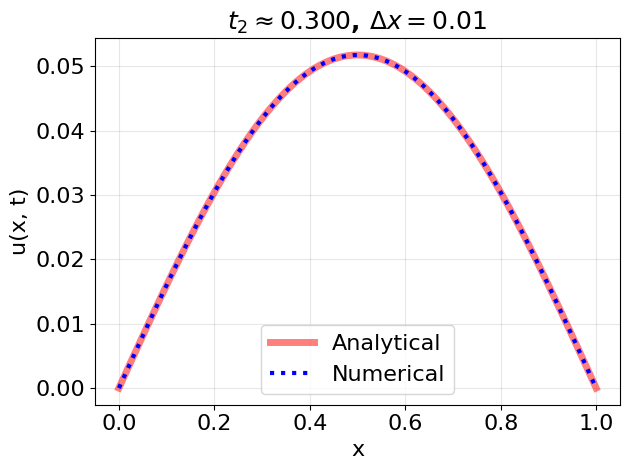

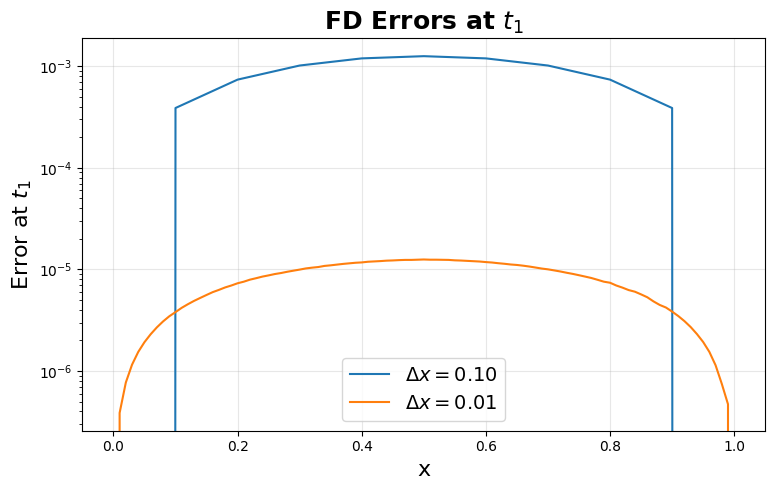

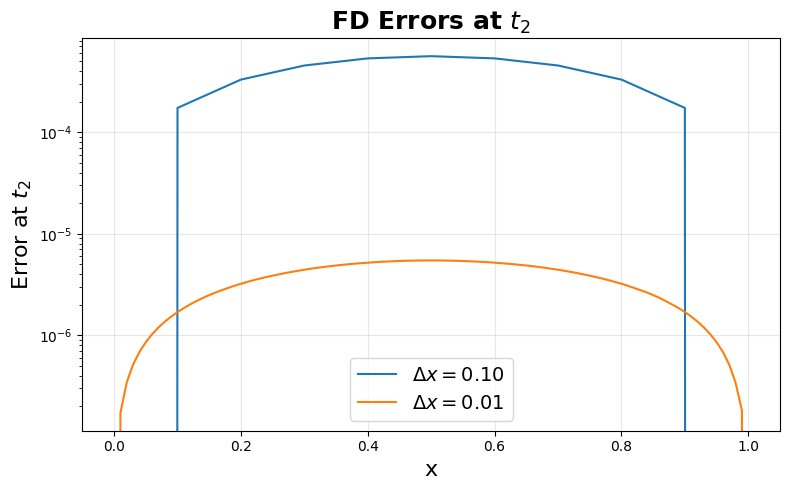

[{'dx': 0.1, 'x': Array([0.        , 0.1       , 0.2       , 0.3       , 0.4       ,
       0.5       , 0.6       , 0.7       , 0.8       , 0.90000004,
       1.        ], dtype=float32), 't1_error': Array([ 0.0000000e+00,  3.8717687e-04,  7.3644519e-04,  1.0136664e-03,
        1.1916161e-03,  1.2529492e-03,  1.1916161e-03,  1.0136664e-03,
        7.3644519e-04,  3.8707256e-04, -4.4443130e-08], dtype=float32), 't2_error': Array([ 0.0000000e+00,  1.7368421e-04,  3.3036619e-04,  4.5471638e-04,
        5.3454563e-04,  5.6205317e-04,  5.3454190e-04,  4.5471266e-04,
        3.3036247e-04,  1.7367303e-04, -4.5987916e-09], dtype=float32)}, {'dx': 0.01, 'x': Array([0.        , 0.01      , 0.02      , 0.03      , 0.04      ,
       0.05      , 0.06      , 0.07      , 0.08      , 0.09      ,
       0.09999999, 0.11      , 0.12      , 0.13      , 0.14      ,
       0.14999999, 0.16      , 0.17      , 0.17999999, 0.19      ,
       0.19999999, 0.21      , 0.22      , 0.22999999, 0.24      ,
      

In [ ]:
errors = []
errors.append(test_explicit_scheme(Nx=10))
errors.append(test_explicit_scheme(Nx=100))

plot_scheme_errors_t1(errors, title="FD Errors at $t_1$", filepath="figs/errors_t1.pdf")
plot_scheme_errors_t2(errors, title="FD Errors at $t_2$", filepath="figs/errors_t2.pdf")

# Part C
Solving same problem as for part b, but now using PINNS

In [ ]:
# ---------- Part c — PINN version of part b ----------
Nx = 100
T = 0.5

_, x, t = fd_solve(Nx=Nx, T=T, alpha=0.4)
u_true = u_exact(x, t)

t1, t2 = 0.07, 0.30
i1 = jnp.argmin(jnp.abs(t - t1))
i2 = jnp.argmin(jnp.abs(t - t2))

model, losses = train_pinn(
    layers=[2, 128, 128, 128, 128, 1], 
    steps=1000,
    N_int=1000,            
    N_ic=200,
    lambda_ic=1.0,
    lambda_bc=1.0,        
    lr=1e-3,
    nu=1.0, 
)

u_pinn, _, _, _ = compare_nn_and_exact(model, Nx=Nx, T=T, return_only=True)


plot_solution(
    x,
    u_pinn[i1],
    u_true[i1],
    title=rf"PINN vs exact at t_1 \approx {float(t[i1]):.3f}",
)

plot_solution(
    x,
    u_pinn[i2],
    u_true[i2],
    title=rf"PINN vs exact at t_2 \approx {float(t[i2]):.3f}",
)

compare_nn_and_exact(model, Nx=Nx, T=T)

plot_training_loss(losses)


# Part c) -Live